<a href="https://colab.research.google.com/github/shashikg/speaker_diarization_ee698/blob/main/LIVE_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries and packages**

In [1]:
!pip install gdown -q
!pip install torchaudio -q --no-deps
!pip install speechbrain -q
!pip install spectralcluster -q
!pip install pyannote.metrics -q

     |████████████████████████████████| 1.9MB 4.4MB/s 
     |████████████████████████████████| 358kB 5.5MB/s 
     |████████████████████████████████| 1.2MB 16.4MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 645kB 22.7MB/s 
     |████████████████████████████████| 552kB 31.0MB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 133kB 17.5MB/s 


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
# Download utilDemo module
!gdown --id 1XttlFwJScsaGnWSrGJFNBECBTJ1inyE-
os.rename('utilsDemo.py', 'utils.py')

# Download DEC module
!gdown --id 1FWIRF2Kq6JB0fFHwjkZmVfEuGq0-SSC5

# Download optimalSpeaker.py
!gdown --id 1hbepzjAxHTQS5QoAlKNP9zK0nMxdjauJ

Downloading...
From: https://drive.google.com/uc?id=1XttlFwJScsaGnWSrGJFNBECBTJ1inyE-
To: /content/utilsDemo.py
100% 9.65k/9.65k [00:00<00:00, 20.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FWIRF2Kq6JB0fFHwjkZmVfEuGq0-SSC5
To: /content/DEC.py
100% 10.1k/10.1k [00:00<00:00, 17.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hbepzjAxHTQS5QoAlKNP9zK0nMxdjauJ
To: /content/optimumSpeaker.py
100% 7.08k/7.08k [00:00<00:00, 6.20MB/s]


In [4]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import os
import torch
from torch.utils.data import Dataset, DataLoader
from speechbrain.pretrained import SpeakerRecognition
import warnings
warnings.filterwarnings('ignore')

from pyannote.database.util import load_rttm
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core import Annotation, Segment, notebook

import cv2
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt

from sklearn.cluster import KMeans, SpectralClustering
from sklearn import decomposition
from tqdm.auto import tqdm

from utils import DiarizationDataSet, make_rttm, get_metrics
import optimumSpeaker
from DEC import diarizationDEC

import shutil
import pandas as pd
from google.colab import files

# **DEMO ON NEWS DEBATE NDTV**

## **Import Debate Data**

In [ ]:
# Demo debate video
!gdown --id 18ukjckXFO4zm6UeR6CDiz3hJQdFammPX

# Demo debate audio
!gdown --id 12yxgfvcK-rqKC1Wd-Ba_fQQji6krGpW-

# Demo debate true labels
!gdown --id 1grAU_M8piW8IhGKkvEliv2HVAL20uRqJ

Downloading...
From: https://drive.google.com/uc?id=18ukjckXFO4zm6UeR6CDiz3hJQdFammPX
To: /content/debate.mp4
30.8MB [00:00, 84.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=12yxgfvcK-rqKC1Wd-Ba_fQQji6krGpW-
To: /content/debate.wav
57.1MB [00:00, 101MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1grAU_M8piW8IhGKkvEliv2HVAL20uRqJ
To: /content/debate.rttm
100% 886/886 [00:00<00:00, 1.32MB/s]


In [ ]:
!mkdir audio
!mkdir label
shutil.move('./debate.wav','./audio/debate.wav')
shutil.move('./debate.rttm','./label/debate.rttm')
print("Files loaded for demo")

mkdir: cannot create directory ‘audio’: File exists
mkdir: cannot create directory ‘label’: File exists
Files loaded for demo


## **Run Diarization**

In [ ]:
if torch.cuda.is_available() == True:
  print("GPU:",torch.cuda.get_device_name(0))
else:
  print('CPU')

GPU: Tesla P100-PCIE-16GB


In [ ]:
audio_dataset = DiarizationDataSet(root_dir='./audio/',
                                   label_dir = './label/',
                                   sr = 16000, window_len = 1500, 
                                   window_step = 750,
                                   transform = None,
                                   batch_size_for_ecapa=512)
print("Number of audio files:",len(audio_dataset))

Downloading: "https://github.com/snakers4/silero-vad/archive/master.zip" to /root/.cache/torch/hub/master.zip


Number of audio files: 1


In [ ]:
hypothesis_dir = diarizationDEC(audio_dataset)

In [ ]:
metric = DiarizationErrorRate()
filename = 'debate.rttm'
groundtruth = load_rttm('./label/debate.rttm')['debate']
hypothesis = load_rttm('./rttm_output/debate.rttm')['debate']
metric(groundtruth, hypothesis)
print(metric)

       diarization error rate  total correct correct false alarm false alarm missed detection missed detection confusion confusion
                            %                      %                       %                                 %                   %
item                                                                                                                              
debate                   3.94 328.28  317.03   96.57        1.67        0.51             7.07             2.16      4.18      1.27
TOTAL                    3.94 328.28  317.03   96.57        1.67        0.51             7.07             2.16      4.18      1.27


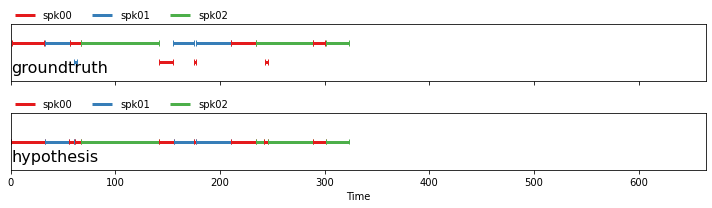

In [ ]:
notebook.width = 10
plt.rcParams['figure.figsize'] = (notebook.width, 3)
# plot reference
plt.subplot(211)
notebook.plot_annotation(groundtruth, legend=True, time=False)
plt.gca().text(0.6, 0.15, 'groundtruth', fontsize=16)

# plot hypothesis
plt.subplot(212)
mapping = metric.optimal_mapping(groundtruth, hypothesis)
notebook.plot_annotation(hypothesis.rename_labels(mapping = mapping), legend=True, time=True)
plt.gca().text(0.6, 0.15, 'hypothesis', fontsize=16)

plt.tight_layout()

plt.show()

## **Video Processing**

In [ ]:
from IPython.display import display
from PIL import Image
!pip install scikit-video -q
from skvideo.io import FFmpegWriter as VideoWriter
!pip install moviepy -q
import moviepy.editor as mpe

In [ ]:
def read_rttm(path):
        '''
        Read RTTM Diarization file
        '''
        rttm_out = [] # returns list of list containing start frame, end frame, spkid
        with open(path, "r") as f:
            for line in f:
                entry = line[:-2].split()
                indexes = [0, 1, 2, 5, 6, 8, 9]
                for index in sorted(indexes, reverse=True):
                    del entry[index]

                entry[0] = int(float(entry[0])*16000) # Start frame
                entry[1] = entry[0] + int(float(entry[1])*16000) # End frame
                entry[2] = int(entry[2][-1:]) # Label
                rttm_out.append(entry)
                
            # Sort rttm list according to start frame
            rttm_out.sort(key = lambda x: x[0])

        return np.array(rttm_out)

def combine_audio(vidname, audname, outname, fps=25):
    my_clip = mpe.VideoFileClip(vidname)
    audio_background = mpe.AudioFileClip(audname)
    final_clip = my_clip.set_audio(audio_background)
    final_clip.write_videofile(outname,fps=fps)

In [ ]:
orig_video_dir = 'debate.mp4'
cap = cv2.VideoCapture(orig_video_dir)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

In [ ]:
hypothesis_labels = read_rttm('./rttm_output/debate.rttm')
hypothesis_labels[:,0] = hypothesis_labels[:,0]*fps/16000 # start time in frames
hypothesis_labels[:,1] = hypothesis_labels[:,1]*fps/16000 # end time in frames
spk_dict = {
    0: "00",
    1: "01",
    2: "02"
}

In [ ]:
# Create video writer
out = VideoWriter('./debate_annotated.mp4', inputdict={'-r': str(fps)}, outputdict={'-r': str(fps)})

if not cap.isOpened(): # check if video file is opened
    cap.open()
frame_count = 0
curr_idx_hypo_array = 0
currspk = "Speaker: None"
while True:
  ret, frame = cap.read()
  frame_count = frame_count + 1
  if ret == False:
    break
  
  # font
  font = cv2.FONT_HERSHEY_TRIPLEX 
  # org
  org = (W//12 , H*3//4)
  # fontScale
  fontScale = 1
  # WHITE color in BGR
  color = (255, 255, 255)
  # Line thickness of 2 px
  thickness = 2
  
  # Get current speaker from hypothesis_labels array
  if hypothesis_labels[curr_idx_hypo_array, 0] > frame_count:
    currspk = "Speaker: None"
  elif hypothesis_labels[curr_idx_hypo_array, 0] <= frame_count and\
    hypothesis_labels[curr_idx_hypo_array, 1] >= frame_count:
    currspk = "Speaker: " + spk_dict[hypothesis_labels[curr_idx_hypo_array, 2]]
  else:
    curr_idx_hypo_array = min(curr_idx_hypo_array + 1, len(hypothesis_labels) - 1)
    currspk = "Speaker: None"

  # Using cv2.putText() method
  frame_annotated = cv2.putText(frame, currspk, org, font, 
                    fontScale, [0,0,0], 2*thickness, cv2.LINE_AA) # Give black outline to text
  frame_annotated = cv2.putText(frame, currspk, org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
  frame_annotated = cv2.cvtColor(frame_annotated, cv2.COLOR_BGR2RGB)
  out.writeFrame(frame_annotated)
cap.release()
out.close()
cv2.destroyAllWindows()

In [ ]:
combine_audio('./debate_annotated.mp4', './audio/debate.wav', './debate_DER_output.mp4',fps = fps)

[MoviePy] >>>> Building video ./debate_DER_output.mp4
[MoviePy] Writing audio in debate_DER_outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 7139/7139 [00:07<00:00, 944.09it/s]

[MoviePy] Done.
[MoviePy] Writing video ./debate_DER_output.mp4



100%|█████████▉| 8090/8091 [01:01<00:00, 130.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./debate_DER_output.mp4 



In [ ]:
from google.colab import files
files.download('debate_DER_output.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **DEMO ON RANDOM PRESENTATION**

## **IMPORT FILES**

In [5]:
# Demo presentation video
!gdown --id 1JjrVmehlEVGqWaBxjcWgsSo8LLVVnsfx 

# Demo presentation audio
!gdown --id 1lmpa7obLUjxCdlepM4grXLM6KQzYnibe

# Demo presentation rttm
!gdown --id 1DI91jSTh8lWBu8ffhad6B6BhiVmwyWto

Downloading...
From: https://drive.google.com/uc?id=1JjrVmehlEVGqWaBxjcWgsSo8LLVVnsfx
To: /content/presentation.mp4
22.6MB [00:00, 138MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1lmpa7obLUjxCdlepM4grXLM6KQzYnibe
To: /content/presentation.wav
27.1MB [00:00, 65.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DI91jSTh8lWBu8ffhad6B6BhiVmwyWto
To: /content/presentation.rttm
100% 69.0/69.0 [00:00<00:00, 126kB/s]


In [6]:
!mkdir audio_pres
!mkdir label_pres
shutil.move('./presentation.wav','./audio_pres/presentation.wav')
shutil.move('./presentation.rttm','./label_pres/presentation.rttm')
print("Files loaded for demo")

Files loaded for demo


In [7]:
if torch.cuda.is_available() == True:
  print("GPU:",torch.cuda.get_device_name(0))
else:
  print('CPU')

GPU: Tesla P100-PCIE-16GB


## **RUN DIARIZATION**

In [8]:
audio_dataset = DiarizationDataSet(root_dir='./audio_pres/',
                                   label_dir = './label_pres/',
                                   sr = 16000, window_len = 1500, 
                                   window_step = 750,
                                   transform = None,
                                   batch_size_for_ecapa=512)
print("Number of audio files:",len(audio_dataset))

Downloading: "https://github.com/snakers4/silero-vad/archive/master.zip" to /root/.cache/torch/hub/master.zip


Number of audio files: 1


In [9]:
hypothesis_dir = diarizationDEC(audio_dataset)

In [10]:
metric = DiarizationErrorRate()
filename = 'presentation.rttm'
groundtruth = load_rttm('./label_pres/presentation.rttm')['presentation']
hypothesis = load_rttm('./rttm_output/presentation.rttm')['presentation']
metric(groundtruth, hypothesis)
print(metric)

             diarization error rate  total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                  %                      %                       %                                 %                   %
item                                                                                                                                    
presentation                  72.64 143.00   40.50   28.32        1.38        0.96            11.62             8.13     90.88     63.55
TOTAL                         72.64 143.00   40.50   28.32        1.38        0.96            11.62             8.13     90.88     63.55


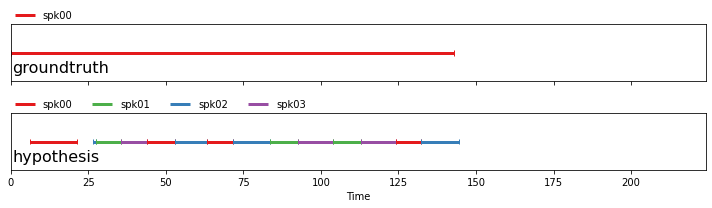

In [11]:
notebook.width = 10
plt.rcParams['figure.figsize'] = (notebook.width, 3)

notebook.crop = Segment(0, 224)
# plot reference
plt.subplot(211)
notebook.plot_annotation(groundtruth, legend=True, time=False)
plt.gca().text(0.6, 0.15, 'groundtruth', fontsize=16)

# plot hypothesis   
plt.subplot(212)
mapping = metric.optimal_mapping(groundtruth, hypothesis)
notebook.plot_annotation(hypothesis.rename_labels(mapping = mapping), legend=True, time=True)
plt.gca().text(0.6, 0.15, 'hypothesis', fontsize=16)

plt.tight_layout()

plt.show()

## **VIDEO PROCESSING**

In [12]:
from IPython.display import display
from PIL import Image
!pip install scikit-video -q
from skvideo.io import FFmpegWriter as VideoWriter
!pip install moviepy -q
import moviepy.editor as mpe

     |████████████████████████████████| 2.3MB 8.2MB/s 
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2916352/45929032 bytes (6.3%)5890048/45929032 bytes (12.8%)9469952/45929032 bytes (20.6%)13139968/45929032 bytes (28.6%)16637952/45929032 bytes (36.2%)20299776/45929032 bytes (44.2%)23912448/45929032 bytes (52.1%)27500544/45929032 bytes (59.9%)31113216/45929032 bytes (67.7%)34570240/45929032 bytes (75.3%)37683200/45929032 bytes (82.0%)399687

In [13]:
def read_rttm(path):
        '''
        Read RTTM Diarization file
        '''
        rttm_out = [] # returns list of list containing start frame, end frame, spkid
        with open(path, "r") as f:
            for line in f:
                entry = line[:-2].split()
                indexes = [0, 1, 2, 5, 6, 8, 9]
                for index in sorted(indexes, reverse=True):
                    del entry[index]

                entry[0] = int(float(entry[0])*16000) # Start frame
                entry[1] = entry[0] + int(float(entry[1])*16000) # End frame
                entry[2] = int(entry[2][-1:]) # Label
                rttm_out.append(entry)
                
            # Sort rttm list according to start frame
            rttm_out.sort(key = lambda x: x[0])

        return np.array(rttm_out)

def combine_audio(vidname, audname, outname, fps=25):
    my_clip = mpe.VideoFileClip(vidname)
    audio_background = mpe.AudioFileClip(audname)
    final_clip = my_clip.set_audio(audio_background)
    final_clip.write_videofile(outname,fps=fps)

In [14]:
orig_video_dir = 'presentation.mp4'
cap = cv2.VideoCapture(orig_video_dir)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

In [15]:
hypothesis_labels = read_rttm('./rttm_output/presentation.rttm')
hypothesis_labels[:,0] = hypothesis_labels[:,0]*fps/16000 # start time in frames
hypothesis_labels[:,1] = hypothesis_labels[:,1]*fps/16000 # end time in frames
spk_dict = {
    0: "00",
    1: "01",
    2: "02",
    3: "03",
    4: "04",
    5: "05",
    6: "06"
}

In [16]:
# Create video writer
out = VideoWriter('./presentation_annotated.mp4', inputdict={'-r': str(fps)}, outputdict={'-r': str(fps)})

if not cap.isOpened(): # check if video file is opened
    cap.open()
frame_count = 0
curr_idx_hypo_array = 0
currspk = "Speaker: None"
while True:
  ret, frame = cap.read()
  frame_count = frame_count + 1
  if ret == False:
    break
  
  # font
  font = cv2.FONT_HERSHEY_TRIPLEX 
  # org
  org = (W//12 , H*3//4)
  # fontScale
  fontScale = 1
  # WHITE color in BGR
  color = (255, 255, 255)
  # Line thickness of 2 px
  thickness = 2
  
  # Get current speaker from hypothesis_labels array
  if hypothesis_labels[curr_idx_hypo_array, 0] > frame_count:
    currspk = "Speaker: None"
  elif hypothesis_labels[curr_idx_hypo_array, 0] <= frame_count and\
    hypothesis_labels[curr_idx_hypo_array, 1] >= frame_count:
    currspk = "Speaker: " + spk_dict[hypothesis_labels[curr_idx_hypo_array, 2]]
  else:
    curr_idx_hypo_array = min(curr_idx_hypo_array + 1, len(hypothesis_labels) - 1)
    currspk = "Speaker: None"

  # Using cv2.putText() method
  frame_annotated = cv2.putText(frame, currspk, org, font, 
                    fontScale, [0,0,0], 2*thickness, cv2.LINE_AA) # Give black outline to text
  frame_annotated = cv2.putText(frame, currspk, org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
  frame_annotated = cv2.cvtColor(frame_annotated, cv2.COLOR_BGR2RGB)
  out.writeFrame(frame_annotated)
cap.release()
out.close()
cv2.destroyAllWindows()

In [17]:
combine_audio('./presentation_annotated.mp4', './audio_pres/presentation.wav', './presentation_DER_output.mp4',fps = fps)

[MoviePy] >>>> Building video ./presentation_DER_output.mp4
[MoviePy] Writing audio in presentation_DER_outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 3392/3392 [00:04<00:00, 691.39it/s]

[MoviePy] Done.
[MoviePy] Writing video ./presentation_DER_output.mp4



100%|██████████| 4610/4610 [04:08<00:00, 18.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./presentation_DER_output.mp4 



In [18]:
from google.colab import files
files.download('presentation_DER_output.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **DEMO ON MOVIE CLIP**

## **IMPORT FILES**

In [35]:
# Demo movie video
!gdown --id 1HhQmVx9E27upvyWvUlZJ7ZLEzsNa7hMC

# Demo movie audio
!gdown --id 1PvXgj1xENBszQ72PTKsD6We7oVJJDDAJ

# Demo movie rttm
!gdown --id 1hBCqCk0C3iMmwjjoztzLcJPCM6pDrVd-

Downloading...
From: https://drive.google.com/uc?id=1HhQmVx9E27upvyWvUlZJ7ZLEzsNa7hMC
To: /content/movie.mp4
15.5MB [00:00, 72.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PvXgj1xENBszQ72PTKsD6We7oVJJDDAJ
To: /content/movie.wav
49.3MB [00:00, 135MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1hBCqCk0C3iMmwjjoztzLcJPCM6pDrVd-
To: /content/movie.rttm
100% 62.0/62.0 [00:00<00:00, 91.7kB/s]


In [36]:
!mkdir audio_movie
!mkdir label_movie
shutil.move('./movie.wav','./audio_movie/movie.wav')
shutil.move('./movie.rttm','./label_movie/movie.rttm')
print("Files loaded for demo")

Files loaded for demo


In [37]:
if torch.cuda.is_available() == True:
  print("GPU:",torch.cuda.get_device_name(0))
else:
  print('CPU')

GPU: Tesla K80


## **Run Diarization**

In [38]:
audio_dataset = DiarizationDataSet(root_dir='./audio_movie/',
                                   label_dir = './label_movie/',
                                   sr = 16000, window_len = 1500, 
                                   window_step = 750,
                                   transform = None,
                                   batch_size_for_ecapa=512)
print("Number of audio files:",len(audio_dataset))

Downloading: "https://github.com/snakers4/silero-vad/archive/master.zip" to /root/.cache/torch/hub/master.zip


Number of audio files: 1


In [39]:
hypothesis_dir = diarizationDEC(audio_dataset)

In [40]:
metric = DiarizationErrorRate()
filename = 'movie.rttm'
groundtruth = load_rttm('./label_movie/movie.rttm')['movie']
hypothesis = load_rttm('./rttm_output/movie.rttm')['movie']
metric(groundtruth, hypothesis)
print(metric)

      diarization error rate  total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                      %                       %                                 %                   %
item                                                                                                                             
movie                  65.05 279.00   97.50   34.95        0.00        0.00            67.50            24.19    114.00     40.86
TOTAL                  65.05 279.00   97.50   34.95        0.00        0.00            67.50            24.19    114.00     40.86


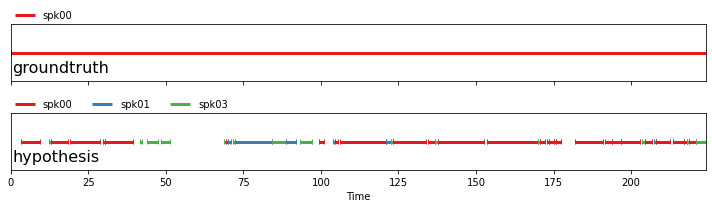

In [41]:
notebook.width = 10
plt.rcParams['figure.figsize'] = (notebook.width, 3)

notebook.crop = Segment(0, 224)
# plot reference
plt.subplot(211)
notebook.plot_annotation(groundtruth, legend=True, time=False)
plt.gca().text(0.6, 0.15, 'groundtruth', fontsize=16)

# plot hypothesis   
plt.subplot(212)
mapping = metric.optimal_mapping(groundtruth, hypothesis)
notebook.plot_annotation(hypothesis.rename_labels(mapping = mapping), legend=True, time=True)
plt.gca().text(0.6, 0.15, 'hypothesis', fontsize=16)

plt.tight_layout()

plt.show()

## **Video Processing**

In [42]:
from IPython.display import display
from PIL import Image
!pip install scikit-video -q
from skvideo.io import FFmpegWriter as VideoWriter
!pip install moviepy -q
import moviepy.editor as mpe

In [43]:
def read_rttm(path):
        '''
        Read RTTM Diarization file
        '''
        rttm_out = [] # returns list of list containing start frame, end frame, spkid
        with open(path, "r") as f:
            for line in f:
                entry = line[:-2].split()
                indexes = [0, 1, 2, 5, 6, 8, 9]
                for index in sorted(indexes, reverse=True):
                    del entry[index]

                entry[0] = int(float(entry[0])*16000) # Start frame
                entry[1] = entry[0] + int(float(entry[1])*16000) # End frame
                entry[2] = int(entry[2][-1:]) # Label
                rttm_out.append(entry)
                
            # Sort rttm list according to start frame
            rttm_out.sort(key = lambda x: x[0])

        return np.array(rttm_out)

def combine_audio(vidname, audname, outname, fps=25):
    my_clip = mpe.VideoFileClip(vidname)
    audio_background = mpe.AudioFileClip(audname)
    final_clip = my_clip.set_audio(audio_background)
    final_clip.write_videofile(outname,fps=fps)

In [59]:
orig_video_dir = 'movie.mp4'
cap = cv2.VideoCapture(orig_video_dir)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

In [55]:
hypothesis_labels = read_rttm('./rttm_output/movie.rttm')
hypothesis_labels[:,0] = hypothesis_labels[:,0]*fps/16000 # start time in frames
hypothesis_labels[:,1] = hypothesis_labels[:,1]*fps/16000 # end time in frames
spk_dict = {
    0: "00",
    1: "01",
    2: "02",
    3: "03",
    4: "04",
    5: "05",
    6: "06",
    7: "07",
    8: "08",
    9: "09",
    10: "10"
}

In [60]:
# Create video writer
out = VideoWriter('./movie_annotated.mp4', inputdict={'-r': str(fps)}, outputdict={'-r': str(fps)})

if not cap.isOpened(): # check if video file is opened
    cap.open()
frame_count = 0
curr_idx_hypo_array = 0
currspk = "Speaker: None"
while True:
  ret, frame = cap.read()
  frame_count = frame_count + 1
  if ret == False:
    break
  
  # font
  font = cv2.FONT_HERSHEY_TRIPLEX 
  # org
  org = (W//12 , H*3//4)
  # fontScale
  fontScale = 1
  # WHITE color in BGR
  color = (255, 255, 255)
  # Line thickness of 2 px
  thickness = 2

  # Get current speaker from hypothesis_labels array
  if hypothesis_labels[curr_idx_hypo_array, 0] > max(0, frame_count - 25):
    currspk = "Speaker: None"
  elif hypothesis_labels[curr_idx_hypo_array, 0] <= max(0, frame_count - 25) and\
    hypothesis_labels[curr_idx_hypo_array, 1] >= max(0, frame_count - 25):
    currspk = "Speaker: " + spk_dict[hypothesis_labels[curr_idx_hypo_array, 2]]
  else:
    curr_idx_hypo_array = min(curr_idx_hypo_array + 1, len(hypothesis_labels) - 1)
    currspk = "Speaker: None"

  # Using cv2.putText() method
  frame_annotated = cv2.putText(frame, currspk, org, font, 
                    fontScale, [0,0,0], 2*thickness, cv2.LINE_AA) # Give black outline to text
  frame_annotated = cv2.putText(frame, currspk, org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
  frame_annotated = cv2.cvtColor(frame_annotated, cv2.COLOR_BGR2RGB)
  out.writeFrame(frame_annotated)
cap.release()
out.close()
cv2.destroyAllWindows()

In [61]:
combine_audio('./movie_annotated.mp4', './audio_movie/movie.wav', './movie_DER_output.mp4',fps = fps)

[MoviePy] >>>> Building video ./movie_DER_output.mp4
[MoviePy] Writing audio in movie_DER_outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 6158/6158 [00:06<00:00, 936.11it/s]

[MoviePy] Done.
[MoviePy] Writing video ./movie_DER_output.mp4



100%|██████████| 6696/6696 [04:53<00:00, 22.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./movie_DER_output.mp4 



In [62]:
from google.colab import files
files.download('movie_DER_output.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>